In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from common.datas import get_mnist_loader
from myDataset import MyDataset as mdatas

from torch.utils.tensorboard import SummaryWriter  
writer = SummaryWriter('./path/to/log')

import time
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
batch_size = 64
num_epochs = 100
in_dim = 80*80
hidden_size = 120
# hidden1_size = 1600
# hidden2_size = 128
# hidden3_size = 10
expect_tho = 0.05

In [9]:
def KL_devergence(p, q):
    """
    Calculate the KL-divergence of (p,q)
    :param p:
    :param q:
    :return:
    """
    q = torch.nn.functional.softmax(q, dim=0)
    q = torch.sum(q, dim=0)/batch_size  # dim:缩减的维度,q的第一维是batch维,即大小为batch_size大小,此处是将第j个神经元在batch_size个输入下所有的输出取平均
    s1 = torch.sum(p*torch.log(p/q))
    s2 = torch.sum((1-p)*torch.log((1-p)/(1-q)))
    return s1+s2

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim, hidden_size, out_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hidden_size),
            nn.ReLU()
           
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return encoder_out, decoder_out

## 自定义数据导入

In [11]:
dataset_path = r'./datasets/train'

In [12]:
dts_class = mdatas(dataset_path,80)
datasets = dts_class.getDatasets()
train_loader = torch.utils.data.DataLoader(datasets,batch_size=batch_size, shuffle=True)


In [13]:
# train_loader, test_loader = get_mnist_loader(batch_size=batch_size, shuffle=True)
# train_loader = get_bligt_datasets_loader(batch_size=batch_size, shuffle=True)

autoEncoder = AutoEncoder(in_dim=in_dim, hidden_size=hidden_size, out_dim=in_dim)
if torch.cuda.is_available():
    autoEncoder.cuda()  # 注:将模型放到GPU上,因此后续传入的数据必须也在GPU上

Loss = nn.BCELoss()
Optimizer = optim.Adam(autoEncoder.parameters(), lr=0.0001)

# 定义期望平均激活值和KL散度的权重
tho_tensor = torch.FloatTensor([expect_tho for _ in range(hidden_size)])
if torch.cuda.is_available():
    tho_tensor = tho_tensor.cuda()
_beta = 2

In [14]:
loss_list = []
for epoch in range(num_epochs):
    time_epoch_start = time.time()
    loss_epoch = [] #存储每个epoch里面的loss
    for batch_index, (train_data, train_label) in enumerate(train_loader):
        if torch.cuda.is_available():
            train_data = train_data.cuda()
            train_label = train_label.cuda()
        print(train_data.size(0))
        input_data = train_data.view(train_data.size(0), -1)
        # print(input_data[0].size)
        encoder_out, decoder_out = autoEncoder(input_data)
        loss = Loss(decoder_out, input_data)

        # 计算并增加KL散度到loss
        _kl = KL_devergence(tho_tensor, encoder_out)
        loss += _beta * _kl

        Optimizer.zero_grad()
        loss.backward()
        Optimizer.step()

        #存储epoch的每个loss值
        loss_epoch.append(loss.item())
        print('Epoch: {}, Loss: {:.4f}, Time: {:.2f}'.format(epoch + 1, loss, time.time() - time_epoch_start))
    #每个epoch的平均loss值
    average_loss =   np.mean(loss_epoch)
    loss_list.append(average_loss)
    writer.add_scalar('loss',average_loss,epoch)


64
Epoch: 80, Loss: 0.6973, Time: 2.09
64
Epoch: 80, Loss: 1.3754, Time: 2.20
64
Epoch: 80, Loss: -0.1369, Time: 2.30
64
Epoch: 80, Loss: 0.2718, Time: 2.41
64
Epoch: 80, Loss: -0.3284, Time: 2.52
64
Epoch: 80, Loss: 0.9337, Time: 2.62
59
Epoch: 80, Loss: -0.1000, Time: 2.72
64
Epoch: 81, Loss: 1.2162, Time: 0.10
64
Epoch: 81, Loss: -0.2574, Time: 0.22
64
Epoch: 81, Loss: 0.7404, Time: 0.32
64
Epoch: 81, Loss: -0.1457, Time: 0.43
64
Epoch: 81, Loss: 0.5322, Time: 0.54
64
Epoch: 81, Loss: -0.6485, Time: 0.64
64
Epoch: 81, Loss: 1.0637, Time: 0.75
64
Epoch: 81, Loss: 1.0300, Time: 0.86
64
Epoch: 81, Loss: -1.7445, Time: 0.96
64
Epoch: 81, Loss: -1.2893, Time: 1.07
64
Epoch: 81, Loss: -1.0407, Time: 1.18
64
Epoch: 81, Loss: 0.8126, Time: 1.27
64
Epoch: 81, Loss: 1.2880, Time: 1.38
64
Epoch: 81, Loss: 0.2430, Time: 1.49
64
Epoch: 81, Loss: -0.5205, Time: 1.61
64
Epoch: 81, Loss: 0.9753, Time: 1.71
64
Epoch: 81, Loss: 0.3254, Time: 1.82
64
Epoch: 81, Loss: 0.8737, Time: 1.92
64
Epoch: 81, 

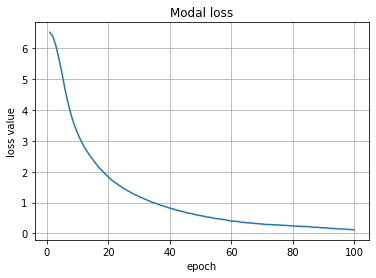

In [25]:
plt.plot([i for i in range(1,num_epochs+1)],loss_list,'-' )
plt.grid()
plt.title('Modal loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.savefig(fname='sae_modal_loss.png',dpi=300,facecolor='w')

In [29]:
torch.save(autoEncoder,'SEAutoEncoder_modal.pkt')